# GMM-UBM Modelling

![title](docs/img/GMM-UBM.png)


To extract unbiased measures of convergence, we used a data-driven, text-independent, automatic speaker identification technique, based on Gaussian Markov Modeling (GMM) Universal Background Model
(UBM). The Gaussian components model the underlying broad phonetic features (i.e., MFCCs) that characterize a speaker's voice and are based on a well-understood statistical model. 

A 32-component UBM was trained with the pooled Solo_Pre speech data of all the participants. Then, individual speaker-dependent models were obtained via maximum a posteriori (MAP) adaptation of the UBMs to the Solo_Pre speech data of each speaker separately. The GMM-UBM has multiple hyperparameters and different settings of these hyperparameters can affect the performance of speaker-dependent models.

A cross-validation technique was used to choose the optimum hyper-parameter settings. Solo_Post speech data were used as a validation set, and each speaker-dependent model's performance was verified against the UBM model

## Run the notebook

In [64]:
# init
import numpy as np
import os
import sidekit
import warnings
warnings.filterwarnings('ignore')
import gmm_scoring_singleThread
from sidekit.bosaris import Scores
from IPython.display import clear_output
import seaborn as sns
from matplotlib import pyplot as plt
import pandas as pd
%matplotlib inline

#read from wav folder, extract mfcc and save it on audio_features folder. train ubm and speaker 
#model, save it on data folder. finally get the prediction score and save it on data folder. 
#use HDFCompass.exe (https://support.hdfgroup.org/projects/compass/download.html) 
#to see whats inside the .h5 files and modify accordingly.

In [2]:
# load wav files and extract features and save it to folder
audioDir = 'wav'
featureDir = 'audio_features'

speakers = np.array(['stella','juliet','shai','ayoub','lucas','simone',
                     'henry', 'julien','marion','elvira'])


# load wav files
fileList = os.listdir(audioDir)
for i in range(0,len(fileList)):
    fileList[i] = fileList[i].replace(".wav", "")
    print(fileList[i])



# feature extraction configuration (read from fileList and save mfcc features in 
# audio_features folder)
extractor = sidekit.FeaturesExtractor(audio_filename_structure=audioDir+"/{}.wav",
                                      feature_filename_structure="./audio_features/{}.h5",
                                      sampling_frequency=22050,
                                      lower_frequency=0,
                                      higher_frequency=6955.4976,
                                      filter_bank="log",
                                      filter_bank_size=40,
                                      window_size=0.025,
                                      shift=0.01,
                                      ceps_number=6,
                                      pre_emphasis=0.97,
                                      save_param=["energy", "cep"],
                                      keep_all_features=True)


for i in range(0,len(fileList)):
    a = './audio_features/' + fileList[i] +'.h5'
    try:
        os.remove(a)
    except OSError:
        pass
    extractor.save(fileList[i])
    
clear_output()

### data formating and Trainnig

file labels for traning validation and testing
train = *-pre , 
validation  = *-post , 
test  = *-duet

In [99]:
#create list of files for UBM traning and save it in data/UBM_List.txt
ubmList =  []
for i in range(0,len(fileList)):
    a = fileList[i].replace('.h5', '')
    b = fileList[i].split('-')
    if b[1][1]== 'r':#pre or train
        ubmList.append(a)
        
with open('data/UBM_List.txt','w') as of:
    of.write("\n".join(ubmList))   

In [100]:
#create traning files and modify them to sidekit file format (i.e. IdMap)
train_subjects_models = []
train_audio_files = []
for i in range(0,len(fileList)):
    a = fileList[i].replace('.h5', '')
    b = fileList[i].split('-')
    if b[1][1]== 'r':#pre or train
        train_subjects_models.append(b[0])
        train_audio_files.append(a)
        
    
# Create and fill the IdMap
train_idmap = sidekit.IdMap()
train_idmap.leftids = np.asarray(train_subjects_models)
train_idmap.rightids = np.asarray(train_audio_files)
train_idmap.start = np.empty(train_idmap.rightids.shape, '|O')
train_idmap.stop = np.empty(train_idmap.rightids.shape, '|O')
train_idmap.validate()
train_idmap.write('data/train_idmap.h5')


ndx = sidekit.Ndx()
ndx.modelset = speakers
ndx.segset = np.array(train_audio_files)
ndx.trialmask = np.ones((len(speakers),len(ndx.segset)), dtype='bool')
ndx.validate()           
ndx.write('data/train.h5')

In [101]:
#create validation files and modify them to sidekit file format (i.e. IdMap, key)
validate_audio_files = []
validate_subjects_models = []
for i in range(0,len(fileList)):
    a = fileList[i].replace('.h5', '')
    b = fileList[i].split('-')
    if b[1][1]== 'o':#post
        validate_subjects_models.append(b[0])  
        validate_audio_files.append(a)
        
        
ndx = sidekit.Ndx()
ndx.modelset = speakers
ndx.segset = np.array(validate_audio_files)
ndx.trialmask = np.ones((len(speakers),len(ndx.segset)), dtype='bool')
ndx.validate()           
ndx.write('data/validation.h5')

segments = [i.split('-', 1)[0] for i in ndx.segset]
seg_index = np.arange(0,len(ndx.segset))

key = sidekit.Key()
key.modelset = ndx.modelset
key.segset = ndx.segset
key.tar = np.zeros((len(speakers),len(ndx.segset)), dtype='bool')
key.non = np.zeros((len(speakers),len(ndx.segset)), dtype='bool')
for s in range(0,len(key.modelset)):
    a = [i for i, x in enumerate(segments) if x == key.modelset[s]]
    a = np.asarray(a)
    key.tar[s, a] = True
    b = np.delete(seg_index, a)    
    key.non[s, b] = True

key.validate()
key.write('data/validation_key.h5')    


In [102]:
#create test files and modify them to sidekit file format (i.e. IdMap, key)
test_audio_files = []
test_subjects_models = []
for i in range(0,len(fileList)):
    a = fileList[i].replace('.h5', '')
    b = fileList[i].split('-')
    if b[1][1]== 'u':#post
        test_subjects_models.append(b[0])  
        test_audio_files.append(a)
        
        
ndx = sidekit.Ndx()
ndx.modelset = speakers
ndx.segset = np.array(test_audio_files)
ndx.trialmask = np.ones((len(speakers),len(ndx.segset)), dtype='bool')
ndx.validate()           
ndx.write('data/test.h5')

segments = [i.split('-', 1)[0] for i in ndx.segset]
seg_index = np.arange(0,len(ndx.segset))

key = sidekit.Key()
key.modelset = ndx.modelset
key.segset = ndx.segset
key.tar = np.zeros((len(speakers),len(ndx.segset)), dtype='bool')
key.non = np.zeros((len(speakers),len(ndx.segset)), dtype='bool')
for s in range(0,len(key.modelset)):
    a = [i for i, x in enumerate(segments) if x == key.modelset[s]]
    a = np.asarray(a)
    key.tar[s, a] = True
    b = np.delete(seg_index, a)    
    key.non[s, b] = True

key.validate()
key.write('data/test_key.h5')    

In [103]:
# Create a FeaturesServer to load features and feed the other methods
features_server = sidekit.FeaturesServer(features_extractor=None,
                                         feature_filename_structure="./audio_features/{}.h5",
                                         sources=None,
                                         dataset_list=["energy", "cep"],
                                         mask="[0-5]",
                                         feat_norm="cmvn",
                                         global_cmvn=None,
                                         dct_pca=False,
                                         dct_pca_config=None,
                                         sdc=False,
                                         sdc_config=None,
                                         delta=True,
                                         double_delta=True,
                                         delta_filter=None,
                                         context=None,
                                         traps_dct_nb=None,
                                         rasta=True,
                                         keep_all_features=True)

In [104]:
# load train, validation, validation_key, UBM files for GMM-UBM traning
train_idmap = sidekit.IdMap('data/train_idmap.h5')
validation_ndx = sidekit.Ndx('data/validation.h5')
key = sidekit.Key('data/validation_key.h5')
with open('data/UBM_List.txt') as inputFile:
        ubmList = inputFile.read().split('\n')

### Testing and get LLR score

In [105]:
# (hyperparameters)
GMM_components = 32 # no of GMM components 
rf = 3  # MAP regulation factor 

model_name = '_GMM-'+str(GMM_components)+'_regFac-'+str(rf)

print(model_name)

_GMM-32_regFac-3


In [106]:
# train UBM
ubm = sidekit.Mixture()
llk = ubm.EM_split(features_server, ubmList, GMM_components, save_partial=False)
ubm.write('data/ubm_model'+model_name+'.h5')
#ubm.read('data/ubm_model'+model_name+'.h5')


In [107]:
#### caution

# this is a workaround because the above process gets stuck sometime
# sidekit uses multiprocess so some time it hangs (need to search a properway to kill 
# all the python spawned process)
#ubm = sidekit.Mixture()
#ubm.write('data/ubm_model'+model_name+'.h5')

In [108]:
# train speaker model (Adapt the GMM speaker models from the UBM via a MAP adaptation)
enroll_stat = sidekit.StatServer(train_idmap,distrib_nb=GMM_components,feature_size=18)
enroll_stat.accumulate_stat(ubm=ubm,feature_server=features_server, 
                            seg_indices=range(enroll_stat.segset.shape[0]))
enroll_stat.write('data/stat_enroll'+model_name+'.h5')

# 
enroll_sv = enroll_stat.adapt_mean_map_multisession(ubm, rf)
enroll_sv.write('data/sv_enroll'+model_name+'.h5')
#enroll_sv.read('data/sv_enroll'+model_name+'.h5')


In [109]:
# predict on the validation data and save it on scores_[model_name].h5
s = np.zeros(validation_ndx.trialmask.shape)
los = np.array_split(np.arange(validation_ndx.segset.shape[0]),1)
for idx in los:
    gmm_scoring_singleThread.gmm_scoring_singleThread(ubm, enroll_sv, validation_ndx, 
                                                      features_server, s,idx)


score = Scores()
score.scoremat = s
score.modelset = validation_ndx.modelset
score.segset = validation_ndx.segset
score.scoremask = validation_ndx.trialmask
score.write('data/validation_scores'+model_name+'.h5')

clear_output()

### Check how well the speaked-dependent model performed on the validation (post) data

Diagonal line should be higher value

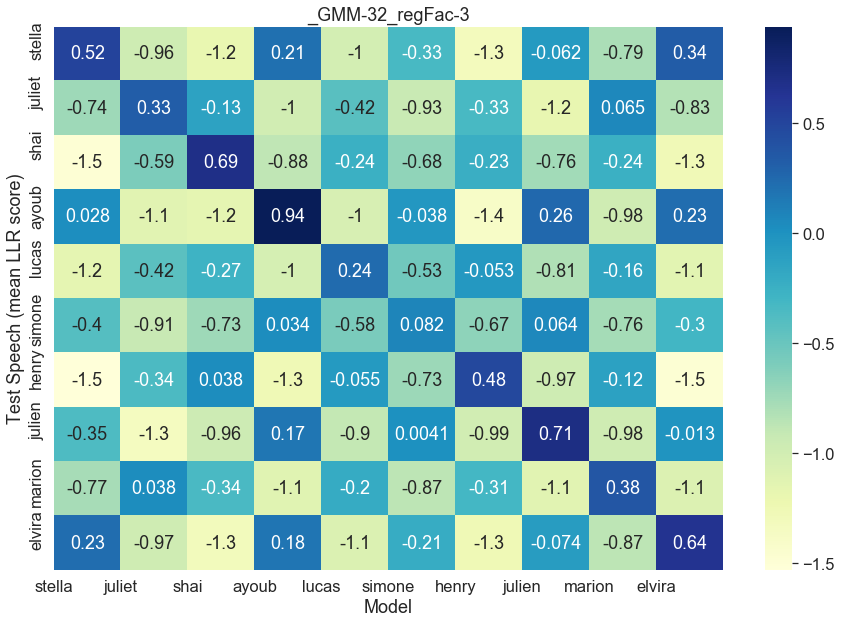

In [96]:
# plot confusion matrix 
A = []

for i in score.modelset:
    a = np.flatnonzero(np.core.defchararray.find(score.segset,i)!=-1)
    A.append(np.mean(score.scoremat[:,a],axis=1))
A = np.stack(A)

f, AX = plt.subplots(figsize=(15,10))

sns.set(font_scale=1.5)

_=sns.heatmap(A,annot=True, cmap="YlGnBu")
plt.xticks(np.arange(0,10),score.modelset)
plt.yticks(np.arange(0,10),score.modelset)
plt.xlabel('Model')
plt.ylabel('Test Speech (mean LLR score)')
_=plt.title(model_name)

### compute duet scores

In [110]:
# compute LLR scores on test speech (duet)
test_ndx = sidekit.Ndx('data/test.h5')

s = np.zeros(test_ndx.trialmask.shape)
los = np.array_split(np.arange(test_ndx.segset.shape[0]),1)
for idx in los:
    gmm_scoring_singleThread.gmm_scoring_singleThread(ubm, enroll_sv, test_ndx, 
                                                      features_server, s,idx)


test_score = Scores()
test_score.scoremat = s
test_score.modelset = test_ndx.modelset
test_score.segset = test_ndx.segset
test_score.scoremask = test_ndx.trialmask
test_score.write('data/test_scores'+model_name+'.h5')

clear_output()

In [111]:
# get all train validation LLR score 
validation_ndx = sidekit.Ndx('data/validation.h5')
s = np.zeros(validation_ndx.trialmask.shape)
los = np.array_split(np.arange(validation_ndx.segset.shape[0]),1)
for idx in los:
    gmm_scoring_singleThread.gmm_scoring_singleThread(ubm, enroll_sv, validation_ndx, 
                                                      features_server, s,idx)


validation_score = Scores()
validation_score.scoremat = s
validation_score.modelset = validation_ndx.modelset
validation_score.segset = validation_ndx.segset
validation_score.scoremask = validation_ndx.trialmask
clear_output()

train_ndx = sidekit.Ndx('data/train.h5')
s = np.zeros(train_ndx.trialmask.shape)
los = np.array_split(np.arange(train_ndx.segset.shape[0]),1)
for idx in los:
    gmm_scoring_singleThread.gmm_scoring_singleThread(ubm, enroll_sv, train_ndx, 
                                                      features_server, s,idx)


train_score = Scores()
train_score.scoremat = s
train_score.modelset = train_ndx.modelset
train_score.segset = train_ndx.segset
train_score.scoremask = train_ndx.trialmask
clear_output()

In [116]:
# create dataframe for train, validation, test scores

A=[]
for j,i in enumerate(test_score.segset):
    a = i.split('-')
    subject = a[0]
    a = a[1].split('_')
    session = a[0]
    wordNo = int(a[1])
    a = pd.Series(test_score.scoremat[:,j],index=['GMM_'+s for s in test_score.modelset])
    
    df = pd.DataFrame({'subject':subject,'session':session,'wordNo':[wordNo]})
    df = pd.concat((df,pd.DataFrame(a).T),axis=1)   
    
    A.append(df)
    
for j,i in enumerate(validation_score.segset):
    a = i.split('-')
    subject = a[0]
    a = a[1].split('_')
    session = a[0]
    wordNo = int(a[1])
    a = pd.Series(validation_score.scoremat[:,j],index=['GMM_'+s for s in 
                                                        validation_score.modelset])
    
    df = pd.DataFrame({'subject':subject,'session':session,'wordNo':[wordNo]})
    df = pd.concat((df,pd.DataFrame(a).T),axis=1)   
    
    A.append(df)    
    
for j,i in enumerate(train_score.segset):
    a = i.split('-')
    subject = a[0]
    a = a[1].split('_')
    session = a[0]
    wordNo = int(a[1])
    a = pd.Series(train_score.scoremat[:,j],index=['GMM_'+s for s in 
                                                        train_score.modelset])
    
    df = pd.DataFrame({'subject':subject,'session':session,'wordNo':[wordNo]})
    df = pd.concat((df,pd.DataFrame(a).T),axis=1)   
    
    A.append(df)
    
A = pd.concat((A),axis=0)   
A['wordIDX'] = A['session'] +'_'+ A['wordNo'].map(str)
A.to_pickle("data/duet_scores.pkl")
A.head()


,subject,session,wordNo,GMM_stella,GMM_juliet,GMM_shai,GMM_ayoub,GMM_lucas,GMM_simone,GMM_henry,GMM_julien,GMM_marion,GMM_elvira,wordIDX
0,ayoub,duet1,10,-0.184212,-1.423853,-0.734895,0.912765,-0.647755,-0.508891,-0.917874,0.097822,-0.527366,-0.282313,duet1_10
0,ayoub,duet1,11,-1.190562,-1.153420,-0.344353,0.858493,-0.830467,-0.375152,-0.539552,0.386372,-0.631205,-0.430392,duet1_11
0,ayoub,duet1,12,0.178006,-0.719921,-1.067169,0.997317,-0.928238,-0.077810,-1.313171,-0.011863,-1.006934,0.274340,duet1_12
0,ayoub,duet1,14,0.134150,-1.760519,-1.527749,0.716158,-1.444427,-0.513346,-1.315987,0.403390,-1.029287,0.753326,duet1_14
0,ayoub,duet1,15,-0.022866,-0.966670,-0.923742,0.890365,-0.919377,-0.280318,-1.470544,-0.333673,-0.684520,0.108646,duet1_15
